# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

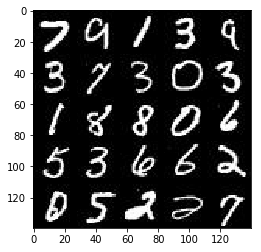

In [2]:
show_n_images = 25


%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

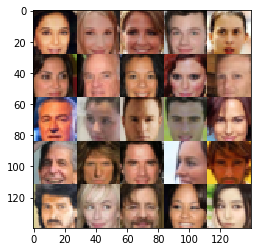

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learing_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #relu2 = tf.nn.dropout(relu2, 0.5)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #relu3 = tf.nn.dropout(relu3, 0.5)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    alpha = 0.01
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = tf.nn.dropout(x1, 0.5)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, 0.5)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #x3 = tf.nn.dropout(x3, 0.5)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    width = data_shape[1]
    height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(width, height, image_channels , z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, image_channels)

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 50
    show_every = 100
    steps_per_epoch = data_shape[0]//batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {}/{}...".format(steps - (epoch_i * steps_per_epoch), steps_per_epoch),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
    return

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 50/1875... Discriminator Loss: 0.3586... Generator Loss: 4.9548
Epoch 1/2... Step 100/1875... Discriminator Loss: 0.9054... Generator Loss: 1.6774


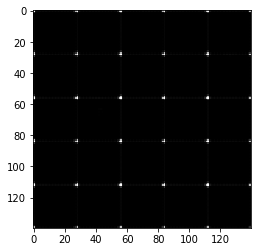

Epoch 1/2... Step 150/1875... Discriminator Loss: 1.0775... Generator Loss: 1.0670
Epoch 1/2... Step 200/1875... Discriminator Loss: 0.8475... Generator Loss: 1.5265


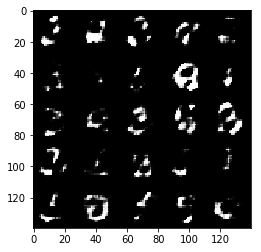

Epoch 1/2... Step 250/1875... Discriminator Loss: 1.5782... Generator Loss: 0.3950
Epoch 1/2... Step 300/1875... Discriminator Loss: 1.4631... Generator Loss: 0.5443


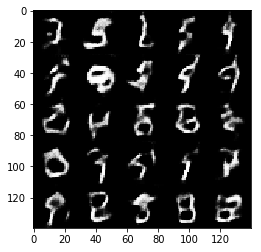

Epoch 1/2... Step 350/1875... Discriminator Loss: 1.2358... Generator Loss: 1.1156
Epoch 1/2... Step 400/1875... Discriminator Loss: 1.2515... Generator Loss: 0.8255


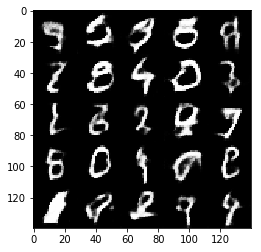

Epoch 1/2... Step 450/1875... Discriminator Loss: 1.2082... Generator Loss: 0.7221
Epoch 1/2... Step 500/1875... Discriminator Loss: 1.1623... Generator Loss: 0.9235


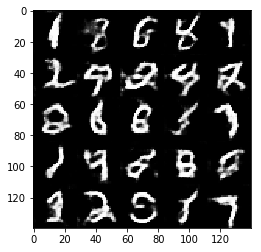

Epoch 1/2... Step 550/1875... Discriminator Loss: 1.3160... Generator Loss: 0.5909
Epoch 1/2... Step 600/1875... Discriminator Loss: 1.2824... Generator Loss: 0.8403


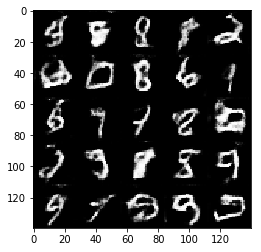

Epoch 1/2... Step 650/1875... Discriminator Loss: 1.0591... Generator Loss: 1.1136
Epoch 1/2... Step 700/1875... Discriminator Loss: 1.2953... Generator Loss: 1.1578


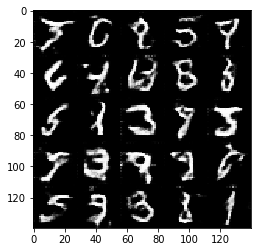

Epoch 1/2... Step 750/1875... Discriminator Loss: 1.2017... Generator Loss: 0.6635
Epoch 1/2... Step 800/1875... Discriminator Loss: 1.1214... Generator Loss: 0.8945


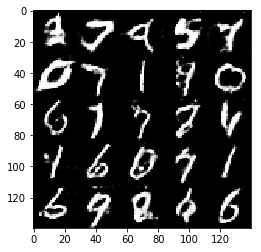

Epoch 1/2... Step 850/1875... Discriminator Loss: 1.1043... Generator Loss: 1.0044
Epoch 1/2... Step 900/1875... Discriminator Loss: 1.0114... Generator Loss: 0.9172


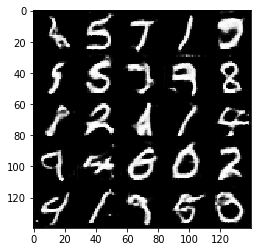

Epoch 1/2... Step 950/1875... Discriminator Loss: 1.0602... Generator Loss: 0.8923
Epoch 1/2... Step 1000/1875... Discriminator Loss: 1.0572... Generator Loss: 1.0062


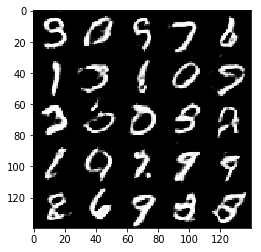

Epoch 1/2... Step 1050/1875... Discriminator Loss: 1.1962... Generator Loss: 1.4240
Epoch 1/2... Step 1100/1875... Discriminator Loss: 1.2860... Generator Loss: 0.6590


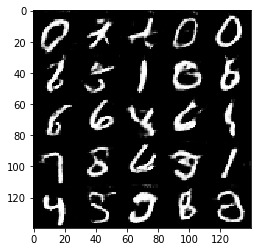

Epoch 1/2... Step 1150/1875... Discriminator Loss: 1.6763... Generator Loss: 0.4239
Epoch 1/2... Step 1200/1875... Discriminator Loss: 1.1337... Generator Loss: 0.7190


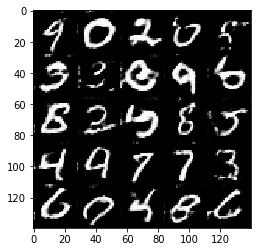

Epoch 1/2... Step 1250/1875... Discriminator Loss: 1.4198... Generator Loss: 0.5920
Epoch 1/2... Step 1300/1875... Discriminator Loss: 0.9683... Generator Loss: 1.0523


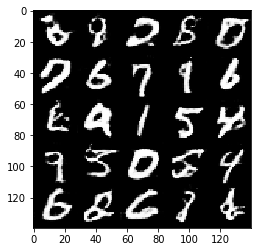

Epoch 1/2... Step 1350/1875... Discriminator Loss: 1.7894... Generator Loss: 2.5180
Epoch 1/2... Step 1400/1875... Discriminator Loss: 1.0131... Generator Loss: 0.9274


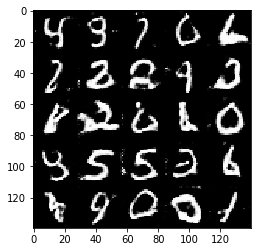

Epoch 1/2... Step 1450/1875... Discriminator Loss: 1.2148... Generator Loss: 0.9263
Epoch 1/2... Step 1500/1875... Discriminator Loss: 1.6418... Generator Loss: 0.4675


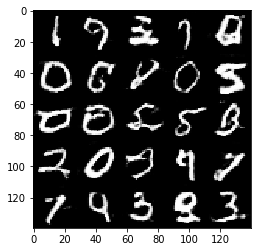

Epoch 1/2... Step 1550/1875... Discriminator Loss: 1.6539... Generator Loss: 0.4423
Epoch 1/2... Step 1600/1875... Discriminator Loss: 1.1659... Generator Loss: 0.7782


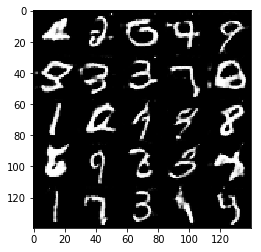

Epoch 1/2... Step 1650/1875... Discriminator Loss: 1.1011... Generator Loss: 1.6706
Epoch 1/2... Step 1700/1875... Discriminator Loss: 1.4485... Generator Loss: 0.4757


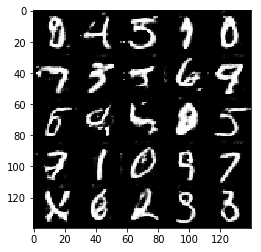

Epoch 1/2... Step 1750/1875... Discriminator Loss: 0.9207... Generator Loss: 1.0360
Epoch 1/2... Step 1800/1875... Discriminator Loss: 1.2016... Generator Loss: 0.8017


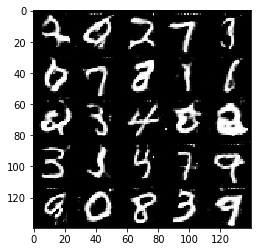

Epoch 1/2... Step 1850/1875... Discriminator Loss: 1.1005... Generator Loss: 0.8634
Epoch 2/2... Step 25/1875... Discriminator Loss: 0.7503... Generator Loss: 1.4825


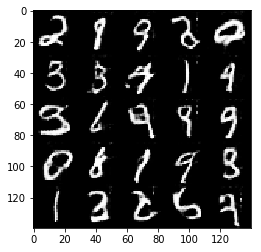

Epoch 2/2... Step 75/1875... Discriminator Loss: 0.7939... Generator Loss: 1.4979
Epoch 2/2... Step 125/1875... Discriminator Loss: 1.0202... Generator Loss: 2.0084


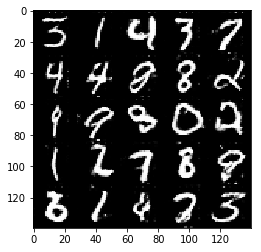

Epoch 2/2... Step 175/1875... Discriminator Loss: 1.6685... Generator Loss: 0.3902
Epoch 2/2... Step 225/1875... Discriminator Loss: 1.2889... Generator Loss: 1.0913


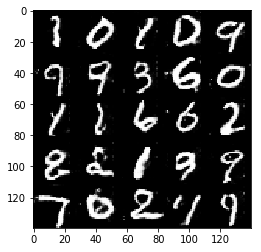

Epoch 2/2... Step 275/1875... Discriminator Loss: 0.8441... Generator Loss: 1.1670
Epoch 2/2... Step 325/1875... Discriminator Loss: 0.8097... Generator Loss: 1.2875


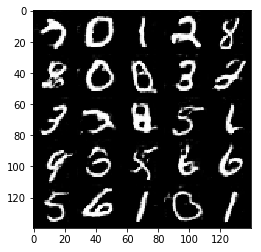

Epoch 2/2... Step 375/1875... Discriminator Loss: 0.9393... Generator Loss: 0.9925
Epoch 2/2... Step 425/1875... Discriminator Loss: 1.0222... Generator Loss: 0.8450


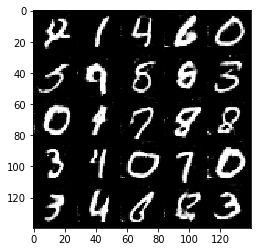

Epoch 2/2... Step 475/1875... Discriminator Loss: 2.2035... Generator Loss: 0.3325
Epoch 2/2... Step 525/1875... Discriminator Loss: 1.0532... Generator Loss: 0.9739


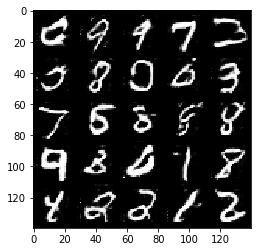

Epoch 2/2... Step 575/1875... Discriminator Loss: 1.1727... Generator Loss: 2.2973
Epoch 2/2... Step 625/1875... Discriminator Loss: 0.8564... Generator Loss: 1.1906


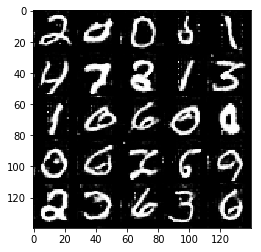

Epoch 2/2... Step 675/1875... Discriminator Loss: 1.0371... Generator Loss: 1.0193
Epoch 2/2... Step 725/1875... Discriminator Loss: 0.9030... Generator Loss: 1.0884


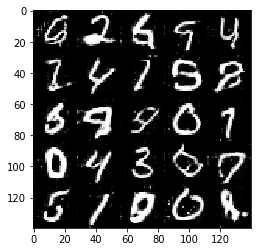

Epoch 2/2... Step 775/1875... Discriminator Loss: 1.1340... Generator Loss: 2.0606
Epoch 2/2... Step 825/1875... Discriminator Loss: 0.8785... Generator Loss: 1.4332


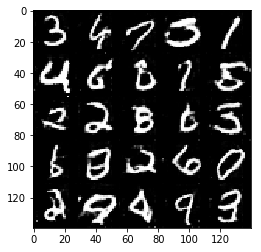

Epoch 2/2... Step 875/1875... Discriminator Loss: 0.8880... Generator Loss: 2.1895
Epoch 2/2... Step 925/1875... Discriminator Loss: 0.9084... Generator Loss: 1.4618


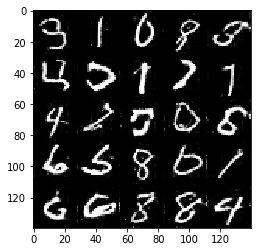

Epoch 2/2... Step 975/1875... Discriminator Loss: 0.7599... Generator Loss: 1.3535
Epoch 2/2... Step 1025/1875... Discriminator Loss: 0.7838... Generator Loss: 1.6795


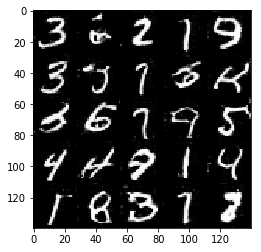

Epoch 2/2... Step 1075/1875... Discriminator Loss: 0.9878... Generator Loss: 0.9698
Epoch 2/2... Step 1125/1875... Discriminator Loss: 0.7122... Generator Loss: 1.6523


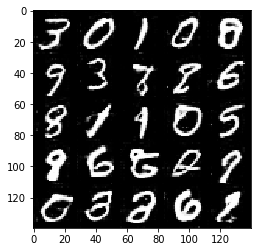

Epoch 2/2... Step 1175/1875... Discriminator Loss: 1.2207... Generator Loss: 0.7267
Epoch 2/2... Step 1225/1875... Discriminator Loss: 0.8963... Generator Loss: 1.2124


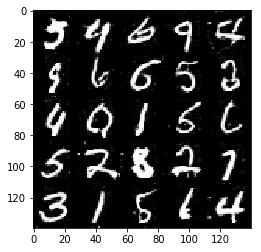

Epoch 2/2... Step 1275/1875... Discriminator Loss: 0.8365... Generator Loss: 1.2230
Epoch 2/2... Step 1325/1875... Discriminator Loss: 0.8219... Generator Loss: 1.4703


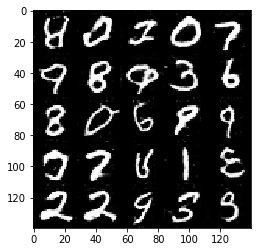

Epoch 2/2... Step 1375/1875... Discriminator Loss: 1.3122... Generator Loss: 0.6165
Epoch 2/2... Step 1425/1875... Discriminator Loss: 0.7982... Generator Loss: 1.3143


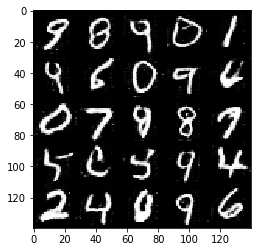

Epoch 2/2... Step 1475/1875... Discriminator Loss: 0.6915... Generator Loss: 1.7735
Epoch 2/2... Step 1525/1875... Discriminator Loss: 1.0850... Generator Loss: 0.8206


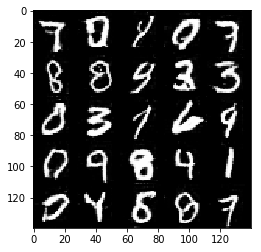

Epoch 2/2... Step 1575/1875... Discriminator Loss: 1.3025... Generator Loss: 0.6429
Epoch 2/2... Step 1625/1875... Discriminator Loss: 1.0623... Generator Loss: 0.8317


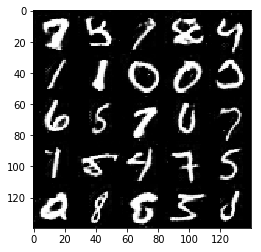

Epoch 2/2... Step 1675/1875... Discriminator Loss: 0.7893... Generator Loss: 1.3476
Epoch 2/2... Step 1725/1875... Discriminator Loss: 1.3732... Generator Loss: 0.5931


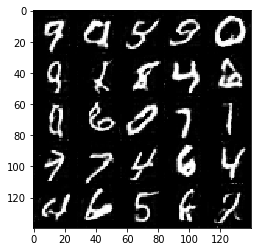

Epoch 2/2... Step 1775/1875... Discriminator Loss: 1.1783... Generator Loss: 0.7754
Epoch 2/2... Step 1825/1875... Discriminator Loss: 0.6821... Generator Loss: 1.6852


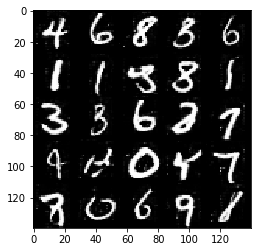

Epoch 2/2... Step 1875/1875... Discriminator Loss: 0.7972... Generator Loss: 2.2016


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 50/6331... Discriminator Loss: 0.3880... Generator Loss: 4.1874
Epoch 1/1... Step 100/6331... Discriminator Loss: 0.7465... Generator Loss: 1.6332


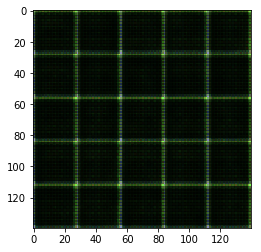

Epoch 1/1... Step 150/6331... Discriminator Loss: 1.1051... Generator Loss: 0.8580
Epoch 1/1... Step 200/6331... Discriminator Loss: 0.3848... Generator Loss: 4.8524


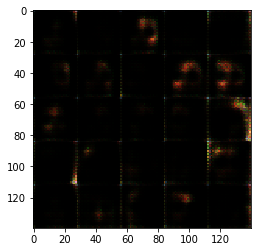

Epoch 1/1... Step 250/6331... Discriminator Loss: 0.4525... Generator Loss: 3.8143
Epoch 1/1... Step 300/6331... Discriminator Loss: 0.7150... Generator Loss: 5.0195


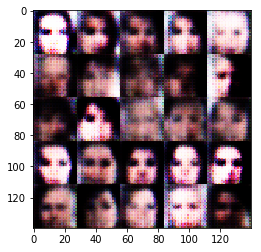

Epoch 1/1... Step 350/6331... Discriminator Loss: 1.3776... Generator Loss: 0.6421
Epoch 1/1... Step 400/6331... Discriminator Loss: 0.7313... Generator Loss: 1.5408


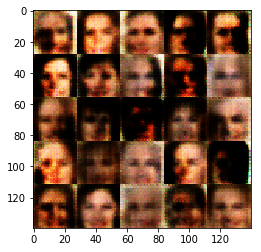

Epoch 1/1... Step 450/6331... Discriminator Loss: 0.7418... Generator Loss: 1.4541
Epoch 1/1... Step 500/6331... Discriminator Loss: 0.5340... Generator Loss: 2.1806


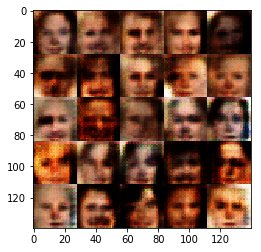

Epoch 1/1... Step 550/6331... Discriminator Loss: 1.0875... Generator Loss: 0.7580
Epoch 1/1... Step 600/6331... Discriminator Loss: 1.4146... Generator Loss: 0.5290


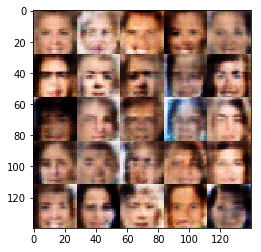

Epoch 1/1... Step 650/6331... Discriminator Loss: 0.9724... Generator Loss: 1.2234
Epoch 1/1... Step 700/6331... Discriminator Loss: 0.9279... Generator Loss: 2.8722


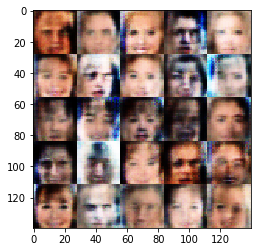

Epoch 1/1... Step 750/6331... Discriminator Loss: 0.9233... Generator Loss: 1.3549
Epoch 1/1... Step 800/6331... Discriminator Loss: 0.5681... Generator Loss: 2.2983


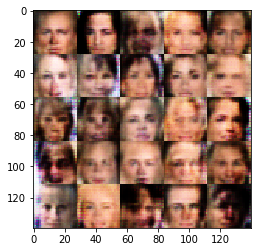

Epoch 1/1... Step 850/6331... Discriminator Loss: 0.8779... Generator Loss: 1.0655
Epoch 1/1... Step 900/6331... Discriminator Loss: 0.7876... Generator Loss: 1.5367


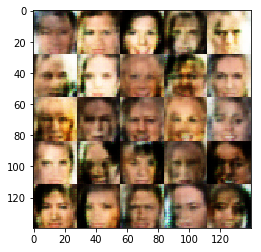

Epoch 1/1... Step 950/6331... Discriminator Loss: 0.7023... Generator Loss: 2.0677
Epoch 1/1... Step 1000/6331... Discriminator Loss: 1.6632... Generator Loss: 0.3556


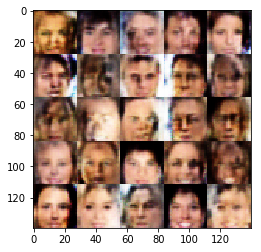

Epoch 1/1... Step 1050/6331... Discriminator Loss: 1.0582... Generator Loss: 0.9434
Epoch 1/1... Step 1100/6331... Discriminator Loss: 1.4480... Generator Loss: 0.4780


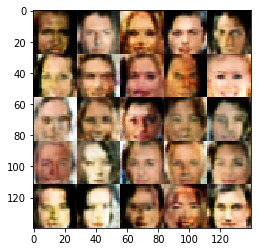

Epoch 1/1... Step 1150/6331... Discriminator Loss: 0.8561... Generator Loss: 1.2961
Epoch 1/1... Step 1200/6331... Discriminator Loss: 1.0124... Generator Loss: 1.0682


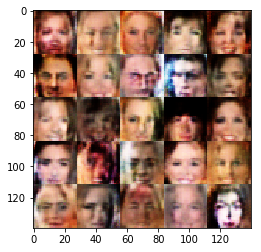

Epoch 1/1... Step 1250/6331... Discriminator Loss: 1.6772... Generator Loss: 0.3447
Epoch 1/1... Step 1300/6331... Discriminator Loss: 1.0684... Generator Loss: 1.3057


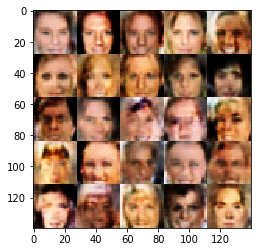

Epoch 1/1... Step 1350/6331... Discriminator Loss: 0.8912... Generator Loss: 1.1156
Epoch 1/1... Step 1400/6331... Discriminator Loss: 0.7190... Generator Loss: 1.8845


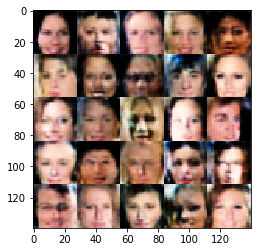

Epoch 1/1... Step 1450/6331... Discriminator Loss: 0.8235... Generator Loss: 1.1303
Epoch 1/1... Step 1500/6331... Discriminator Loss: 0.5480... Generator Loss: 2.2437


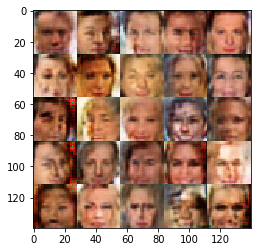

Epoch 1/1... Step 1550/6331... Discriminator Loss: 1.2554... Generator Loss: 0.9582
Epoch 1/1... Step 1600/6331... Discriminator Loss: 1.3196... Generator Loss: 0.5445


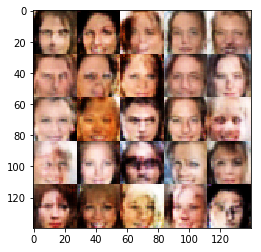

Epoch 1/1... Step 1650/6331... Discriminator Loss: 1.0116... Generator Loss: 0.7927
Epoch 1/1... Step 1700/6331... Discriminator Loss: 0.9757... Generator Loss: 0.8326


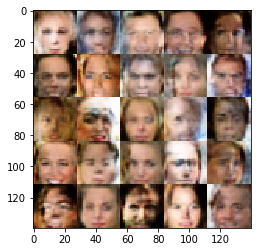

Epoch 1/1... Step 1750/6331... Discriminator Loss: 0.8321... Generator Loss: 1.2408
Epoch 1/1... Step 1800/6331... Discriminator Loss: 1.5526... Generator Loss: 0.4059


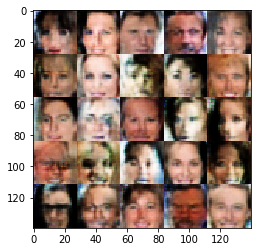

Epoch 1/1... Step 1850/6331... Discriminator Loss: 1.8622... Generator Loss: 0.2786
Epoch 1/1... Step 1900/6331... Discriminator Loss: 1.6967... Generator Loss: 0.3687


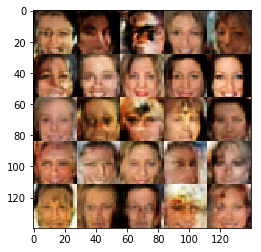

Epoch 1/1... Step 1950/6331... Discriminator Loss: 1.3143... Generator Loss: 0.8968
Epoch 1/1... Step 2000/6331... Discriminator Loss: 1.2998... Generator Loss: 0.5581


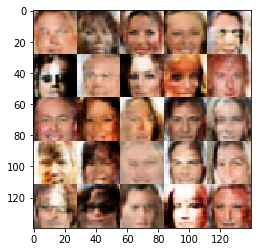

Epoch 1/1... Step 2050/6331... Discriminator Loss: 0.7973... Generator Loss: 4.5264
Epoch 1/1... Step 2100/6331... Discriminator Loss: 1.0186... Generator Loss: 1.0910


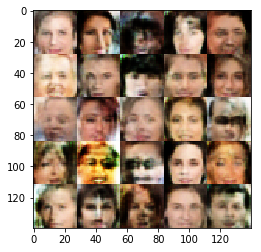

Epoch 1/1... Step 2150/6331... Discriminator Loss: 0.9517... Generator Loss: 0.9991
Epoch 1/1... Step 2200/6331... Discriminator Loss: 1.0660... Generator Loss: 0.7769


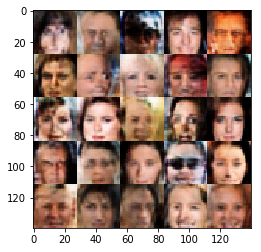

Epoch 1/1... Step 2250/6331... Discriminator Loss: 1.4272... Generator Loss: 0.5708
Epoch 1/1... Step 2300/6331... Discriminator Loss: 0.6187... Generator Loss: 2.1469


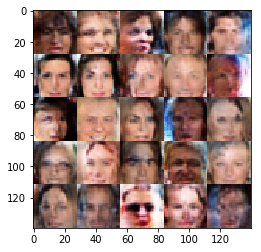

Epoch 1/1... Step 2350/6331... Discriminator Loss: 1.6799... Generator Loss: 0.3336
Epoch 1/1... Step 2400/6331... Discriminator Loss: 0.9376... Generator Loss: 1.1279


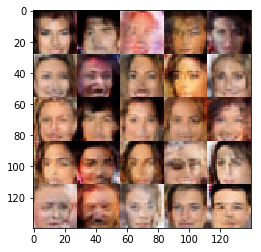

Epoch 1/1... Step 2450/6331... Discriminator Loss: 0.8742... Generator Loss: 1.4288
Epoch 1/1... Step 2500/6331... Discriminator Loss: 0.4829... Generator Loss: 3.0201


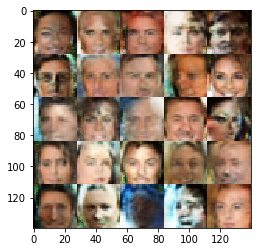

Epoch 1/1... Step 2550/6331... Discriminator Loss: 1.9508... Generator Loss: 0.2541
Epoch 1/1... Step 2600/6331... Discriminator Loss: 0.4687... Generator Loss: 5.3402


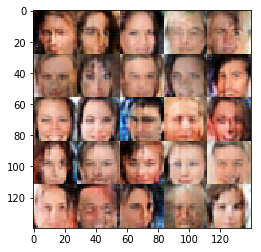

Epoch 1/1... Step 2650/6331... Discriminator Loss: 1.3257... Generator Loss: 0.8340
Epoch 1/1... Step 2700/6331... Discriminator Loss: 1.2757... Generator Loss: 1.1944


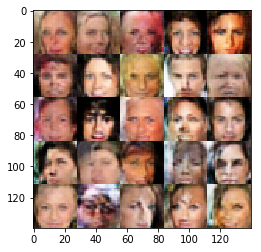

Epoch 1/1... Step 2750/6331... Discriminator Loss: 1.0197... Generator Loss: 0.8578
Epoch 1/1... Step 2800/6331... Discriminator Loss: 1.1625... Generator Loss: 0.7004


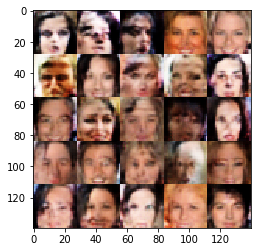

Epoch 1/1... Step 2850/6331... Discriminator Loss: 1.2199... Generator Loss: 0.7598
Epoch 1/1... Step 2900/6331... Discriminator Loss: 1.0801... Generator Loss: 0.9141


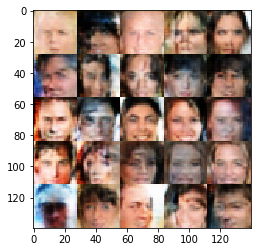

Epoch 1/1... Step 2950/6331... Discriminator Loss: 1.1112... Generator Loss: 1.4037
Epoch 1/1... Step 3000/6331... Discriminator Loss: 1.0778... Generator Loss: 0.9550


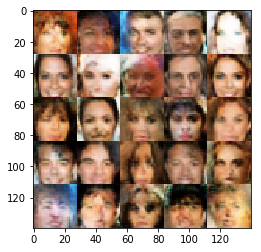

Epoch 1/1... Step 3050/6331... Discriminator Loss: 1.2659... Generator Loss: 0.6951
Epoch 1/1... Step 3100/6331... Discriminator Loss: 1.3350... Generator Loss: 0.6801


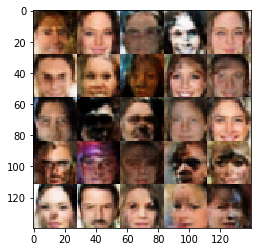

Epoch 1/1... Step 3150/6331... Discriminator Loss: 1.1238... Generator Loss: 1.2258
Epoch 1/1... Step 3200/6331... Discriminator Loss: 1.0393... Generator Loss: 0.8303


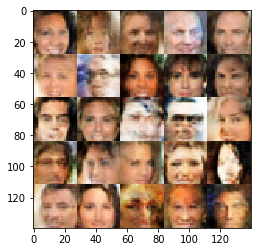

Epoch 1/1... Step 3250/6331... Discriminator Loss: 1.0278... Generator Loss: 1.3217
Epoch 1/1... Step 3300/6331... Discriminator Loss: 1.1017... Generator Loss: 1.0056


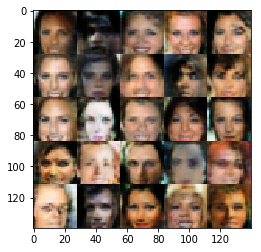

Epoch 1/1... Step 3350/6331... Discriminator Loss: 1.3057... Generator Loss: 0.6987
Epoch 1/1... Step 3400/6331... Discriminator Loss: 1.5649... Generator Loss: 0.4089


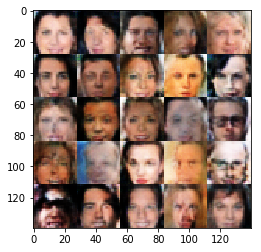

Epoch 1/1... Step 3450/6331... Discriminator Loss: 1.3099... Generator Loss: 0.7964
Epoch 1/1... Step 3500/6331... Discriminator Loss: 1.2096... Generator Loss: 1.4674


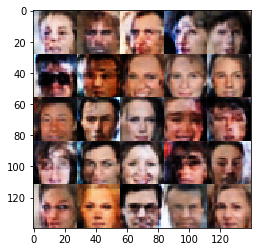

Epoch 1/1... Step 3550/6331... Discriminator Loss: 1.9627... Generator Loss: 0.2710
Epoch 1/1... Step 3600/6331... Discriminator Loss: 1.0068... Generator Loss: 0.9182


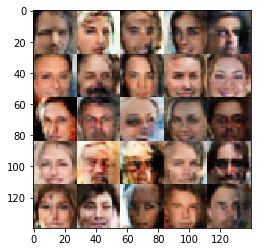

Epoch 1/1... Step 3650/6331... Discriminator Loss: 1.1737... Generator Loss: 0.7027
Epoch 1/1... Step 3700/6331... Discriminator Loss: 1.3493... Generator Loss: 1.0954


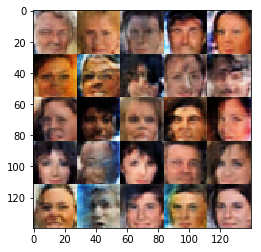

Epoch 1/1... Step 3750/6331... Discriminator Loss: 1.3465... Generator Loss: 0.7611
Epoch 1/1... Step 3800/6331... Discriminator Loss: 1.2619... Generator Loss: 0.9345


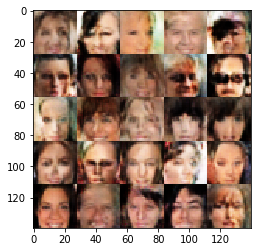

Epoch 1/1... Step 3850/6331... Discriminator Loss: 1.6709... Generator Loss: 0.4119
Epoch 1/1... Step 3900/6331... Discriminator Loss: 1.0801... Generator Loss: 1.0180


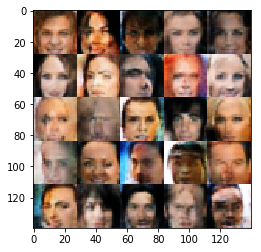

Epoch 1/1... Step 3950/6331... Discriminator Loss: 1.2454... Generator Loss: 0.6055
Epoch 1/1... Step 4000/6331... Discriminator Loss: 1.3563... Generator Loss: 0.5718


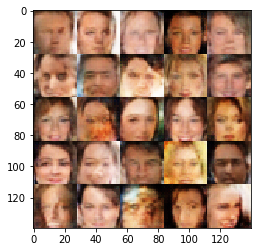

Epoch 1/1... Step 4050/6331... Discriminator Loss: 1.0887... Generator Loss: 0.8409
Epoch 1/1... Step 4100/6331... Discriminator Loss: 1.4084... Generator Loss: 0.5180


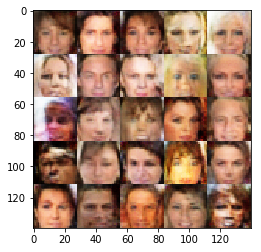

Epoch 1/1... Step 4150/6331... Discriminator Loss: 1.0566... Generator Loss: 1.2011
Epoch 1/1... Step 4200/6331... Discriminator Loss: 1.2914... Generator Loss: 0.7167


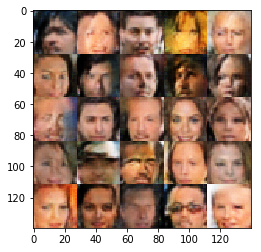

Epoch 1/1... Step 4250/6331... Discriminator Loss: 0.5638... Generator Loss: 1.9274
Epoch 1/1... Step 4300/6331... Discriminator Loss: 0.6636... Generator Loss: 1.9805


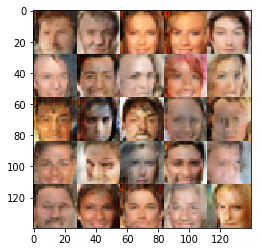

Epoch 1/1... Step 4350/6331... Discriminator Loss: 1.3581... Generator Loss: 0.7264
Epoch 1/1... Step 4400/6331... Discriminator Loss: 1.2685... Generator Loss: 0.7468


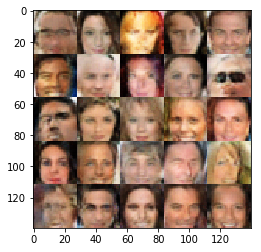

Epoch 1/1... Step 4450/6331... Discriminator Loss: 1.3800... Generator Loss: 0.5183
Epoch 1/1... Step 4500/6331... Discriminator Loss: 1.1655... Generator Loss: 0.9654


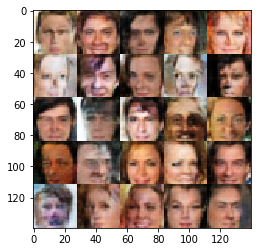

Epoch 1/1... Step 4550/6331... Discriminator Loss: 1.3567... Generator Loss: 0.6335
Epoch 1/1... Step 4600/6331... Discriminator Loss: 1.0368... Generator Loss: 0.7481


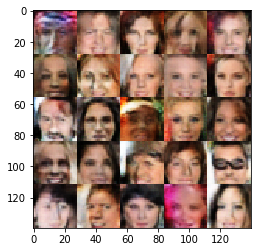

Epoch 1/1... Step 4650/6331... Discriminator Loss: 1.3033... Generator Loss: 0.8026
Epoch 1/1... Step 4700/6331... Discriminator Loss: 1.1253... Generator Loss: 0.7776


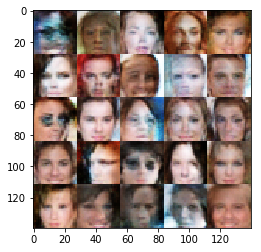

Epoch 1/1... Step 4750/6331... Discriminator Loss: 1.8549... Generator Loss: 0.3456
Epoch 1/1... Step 4800/6331... Discriminator Loss: 1.1694... Generator Loss: 0.8697


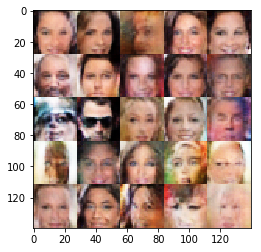

Epoch 1/1... Step 4850/6331... Discriminator Loss: 1.2214... Generator Loss: 0.7001
Epoch 1/1... Step 4900/6331... Discriminator Loss: 1.4666... Generator Loss: 0.6319


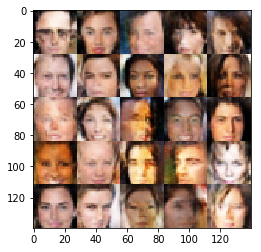

Epoch 1/1... Step 4950/6331... Discriminator Loss: 0.9700... Generator Loss: 1.1688
Epoch 1/1... Step 5000/6331... Discriminator Loss: 1.3465... Generator Loss: 0.6260


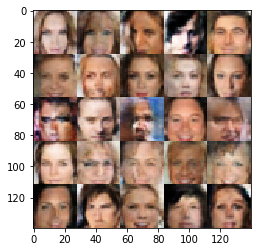

Epoch 1/1... Step 5050/6331... Discriminator Loss: 1.4450... Generator Loss: 0.7421
Epoch 1/1... Step 5100/6331... Discriminator Loss: 1.2710... Generator Loss: 0.6539


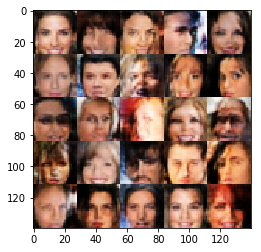

Epoch 1/1... Step 5150/6331... Discriminator Loss: 0.7666... Generator Loss: 1.4263
Epoch 1/1... Step 5200/6331... Discriminator Loss: 1.2727... Generator Loss: 0.7418


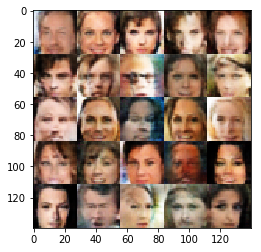

Epoch 1/1... Step 5250/6331... Discriminator Loss: 1.4264... Generator Loss: 0.7672
Epoch 1/1... Step 5300/6331... Discriminator Loss: 1.1646... Generator Loss: 0.6974


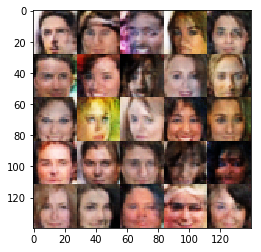

Epoch 1/1... Step 5350/6331... Discriminator Loss: 1.2107... Generator Loss: 0.7159
Epoch 1/1... Step 5400/6331... Discriminator Loss: 1.5098... Generator Loss: 0.5883


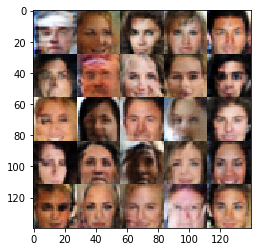

Epoch 1/1... Step 5450/6331... Discriminator Loss: 1.4441... Generator Loss: 0.7020
Epoch 1/1... Step 5500/6331... Discriminator Loss: 1.0297... Generator Loss: 1.4130


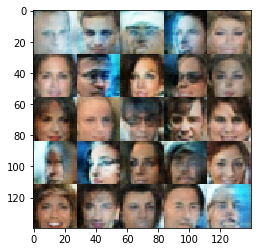

Epoch 1/1... Step 5550/6331... Discriminator Loss: 0.5855... Generator Loss: 2.5973
Epoch 1/1... Step 5600/6331... Discriminator Loss: 1.3112... Generator Loss: 0.6962


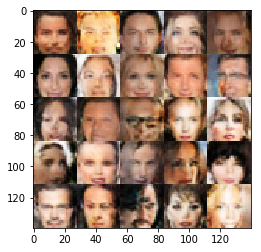

Epoch 1/1... Step 5650/6331... Discriminator Loss: 1.5693... Generator Loss: 0.4271
Epoch 1/1... Step 5700/6331... Discriminator Loss: 1.3453... Generator Loss: 0.5737


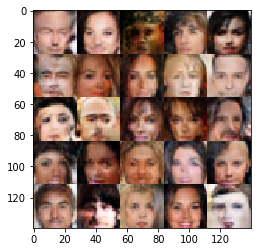

Epoch 1/1... Step 5750/6331... Discriminator Loss: 1.3900... Generator Loss: 0.5740
Epoch 1/1... Step 5800/6331... Discriminator Loss: 1.4614... Generator Loss: 0.5475


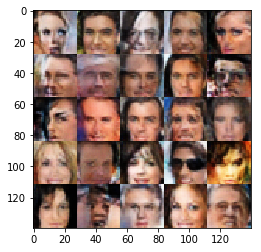

Epoch 1/1... Step 5850/6331... Discriminator Loss: 1.2633... Generator Loss: 0.6182
Epoch 1/1... Step 5900/6331... Discriminator Loss: 1.4643... Generator Loss: 0.5402


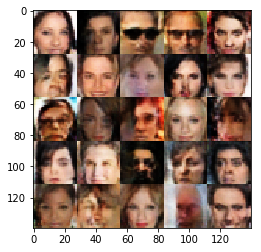

Epoch 1/1... Step 5950/6331... Discriminator Loss: 1.5108... Generator Loss: 0.4766
Epoch 1/1... Step 6000/6331... Discriminator Loss: 1.1342... Generator Loss: 0.7543


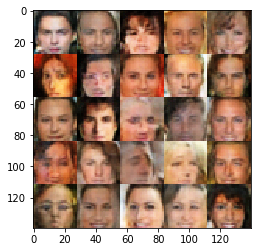

Epoch 1/1... Step 6050/6331... Discriminator Loss: 1.4182... Generator Loss: 0.5573
Epoch 1/1... Step 6100/6331... Discriminator Loss: 1.6892... Generator Loss: 0.4589


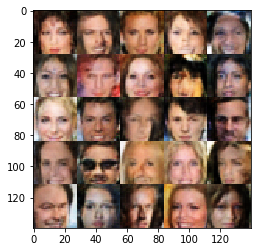

Epoch 1/1... Step 6150/6331... Discriminator Loss: 1.2832... Generator Loss: 0.6682
Epoch 1/1... Step 6200/6331... Discriminator Loss: 1.6631... Generator Loss: 0.4485


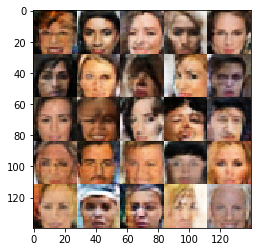

Epoch 1/1... Step 6250/6331... Discriminator Loss: 1.6090... Generator Loss: 0.3908
Epoch 1/1... Step 6300/6331... Discriminator Loss: 1.4202... Generator Loss: 0.5857


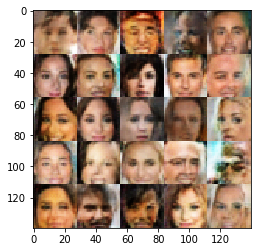

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.